## CRISP-DM Framework - Data mining

## SALES ANALYSIS AND PREDICTION MODEL

### 1. Business Understanding
The main goal of this project is to predict how much fresh produce will sell in the future. This helps with better stock planning, less waste, and smarter pricing.
The primary objectives of this analysis were to:
	Integrate disparate datasets containing product information, transaction records, wholesale pricing, and loss metrics into a unified analytical framework
	Identify key factors influencing sales quantities across different product categories
	Develop a predictive model capable of forecasting future sales quantities with acceptable accuracy
	Provide actionable insights to optimize inventory management and pricing strategies


###  2. Data Understanding
Data Collection:The data is collected from kaggle.

Data Description:
The analysis incorporated four distinct datasets, each providing complementary information essential for comprehensive modelling:

annex1.csv: Product metadata (e.g., category codes, item details)

annex2.csv: Transaction-level sales data (quantity sold, unit price, returns, discounts)

annex3.csv: Wholesale pricing data

annex4.csv: Product loss rates


In [33]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_csv("annex1.csv")
df2 = pd.read_csv("annex2.csv")
df3 = pd.read_csv("annex3.csv")
df4 = pd.read_csv("annex4.csv")

### **Dataset Information**

In [34]:
print(df1.shape)
df1.head()

(251, 4)


,Item Code,Item Name,Category Code,Category Name
0,102900005115168,Niushou Shengcai,1011010101,Flower/Leaf Vegetables
1,102900005115199,Sichuan Red Cedar,1011010101,Flower/Leaf Vegetables
2,102900005115625,Local Xiaomao Cabbage,1011010101,Flower/Leaf Vegetables
3,102900005115748,White Caitai,1011010101,Flower/Leaf Vegetables
4,102900005115762,Amaranth,1011010101,Flower/Leaf Vegetables


In [35]:
print(df2.shape)
df2.head()

(878503, 7)


,Date,Time,Item Code,Quantity Sold (kilo),Unit Selling Price (RMB/kg),Sale or Return,Discount (Yes/No)
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,sale,No
1,2020-07-01,09:17:27.295,102900005115960,0.849,3.2,sale,No
2,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,sale,No
3,2020-07-01,09:19:45.450,102900005115823,0.421,10.0,sale,No
4,2020-07-01,09:20:23.686,102900005115908,0.539,8.0,sale,No


In [36]:
print(df3.shape)
df3.head()

(55982, 3)


,Date,Item Code,Wholesale Price (RMB/kg)
0,2020-07-01,102900005115762,3.88
1,2020-07-01,102900005115779,6.72
2,2020-07-01,102900005115786,3.19
3,2020-07-01,102900005115793,9.24
4,2020-07-01,102900005115823,7.03


In [37]:
print(df4.shape)
df4.head()

(251, 3)


,Item Code,Item Name,Loss Rate (%)
0,102900005115168,Niushou Shengcai,4.39
1,102900005115199,Sichuan Red Cedar,10.46
2,102900005115250,Xixia Black Mushroom (1),10.80
3,102900005115625,Local Xiaomao Cabbage,0.18
4,102900005115748,White Caitai,8.78


### Data Preparation
After loading the dataset, it is important to clean and arrange the dataset, as raw dataset may contains missing values.
We followed a step-by-step process to create one clean dataset, ready for analysis and modeling:

1.Summarizing Sales Data (from Annex 2):
added up the total quantity sold for each product every day.
calculated the average price each product was sold at per day.                              counted how many sales transactions happened (based on “Sale or Return”).
also counted how many of those sales were discounted.

2.Merging All the Data:

First,  joined the daily sales data with wholesale prices (Annex 3) using the product and date.
Then we added product information (Annex 1) using the product code.
Finally,  added the loss rate (Annex 4), again using the product code.

3.Cleaning and Fixing the Data:

	Missing wholesale prices were imputed using the median value across the dataseto	Missing loss rates were replaced with zero
	Category codes were converted to string format for consistency
	Dates were converted to timestamp format (seconds since epoch) to enable temporal analysis and modeling




In [38]:
df2_agg = df2.groupby(["Date", "Item Code"]).agg({
    "Quantity Sold (kilo)": "sum",  # Total quantity sold per day
    "Unit Selling Price (RMB/kg)": "mean",  # Average selling price per day
    "Sale or Return": "count",  # Total transactions per day
    "Discount (Yes/No)": lambda x: (x == "Yes").sum()  # Total discounted sales per day
}).reset_index()
sales_wholesale = df2_agg.merge(df3, on=["Date", "Item Code"], how="left")
sales_wholesale = sales_wholesale.merge(df1, on="Item Code", how="left")
final_df = sales_wholesale.merge(df4[['Item Code', 'Loss Rate (%)']], on="Item Code", how="left")
final_df.fillna({"Wholesale Price": final_df["Wholesale Price (RMB/kg)"].median(), "Loss Rate (%)": 0}, inplace=True)
final_df["Category Code"] = final_df["Category Code"].astype(str)
final_df["Date"] = pd.to_datetime(final_df["Date"])
final_df["Date"] = final_df["Date"].astype(int) / 10**9  # Convert to timestamp
final_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46599 entries, 0 to 46598
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         46599 non-null  float64
 1   Item Code                    46599 non-null  int64  
 2   Quantity Sold (kilo)         46599 non-null  float64
 3   Unit Selling Price (RMB/kg)  46599 non-null  float64
 4   Sale or Return               46599 non-null  int64  
 5   Discount (Yes/No)            46599 non-null  int64  
 6   Wholesale Price (RMB/kg)     46599 non-null  float64
 7   Item Name                    46599 non-null  object 
 8   Category Code                46599 non-null  object 
 9   Category Name                46599 non-null  object 
 10  Loss Rate (%)                46599 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 3.9+ MB


 Resulting Dataset Structure
The integration process resulted in a comprehensive dataset with the following characteristics:
•	Records: 46,599 observations
•	Variables: 11 attributes combining product information, sales metrics, pricing data, and loss rates
•	Time period: From July 1, 2020 (as observed in sample data) forward


In [39]:
print(final_df.shape)
final_df.head()

(46599, 11)


,Date,Item Code,Quantity Sold (kilo),Unit Selling Price (RMB/kg),Sale or Return,Discount (Yes/No),Wholesale Price (RMB/kg),Item Name,Category Code,Category Name,Loss Rate (%)
0,1.593562e+09,102900005115762,6.841,6.0,11,0,3.88,Amaranth,1011010101,Flower/Leaf Vegetables,18.52
1,1.593562e+09,102900005115779,41.966,8.0,114,0,6.72,Yunnan Shengcai,1011010101,Flower/Leaf Vegetables,15.25
2,1.593562e+09,102900005115786,11.352,6.0,24,0,3.19,Zhuyecai,1011010101,Flower/Leaf Vegetables,13.62
3,1.593562e+09,102900005115793,4.288,16.0,11,0,9.24,Chinese Cabbage,1011010101,Flower/Leaf Vegetables,7.59
4,1.593562e+09,102900005115823,11.476,10.0,28,0,7.03,Shanghaiqing,1011010101,Flower/Leaf Vegetables,14.43


### 4.Modelling
### **KNN Model Implementation**


For the predictive model, six key features were carefully selected based on their theoretical and empirical relationships with sales quantity:
•	Date (temporal component)
•	Unit Selling Price (RMB/kg)
•	Wholesale Price (RMB/kg)
•	Sale or Return (transaction count)
•	Discount (Yes/No)
•	Loss Rate (%).
These predictors were selected to represent a comprehensive set of demand factors, supply conditions, and product attributes that collectively determine sales quantities in the fresh produce context.
The K-Nearest Neighbors regression algorithm was implemented with the following configuration:
Key model parameters:
•	Number of neighbors (k=5): Five nearest neighbors are used to generate predictions, balancing the trade-off between bias and variance. This parameter value was selected to provide sufficient local information while avoiding overfitting to noise in the data.

•	Distance metric (Euclidean): Euclidean distance was selected as the distance metric, measuring the straight-line distance between points in the feature space. This metric is particularly appropriate for continuous features after standardization.
The KNN regression operates by:
1.	Calculating the distance between a query point and all training examples
2.	Identifying the k-nearest neighbors based on these distances
3.	Averaging the target values (quantity sold) of these neighbors to produce a prediction
This non-parametric approach is advantageous for capturing complex, non-linear relationships without making explicit assumptions about the underlying data distribution.


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Select Features (X) and Target (y)
X = final_df[["Date", "Unit Selling Price (RMB/kg)", "Wholesale Price (RMB/kg)", 
        "Sale or Return", "Discount (Yes/No)", "Loss Rate (%)"]]

y = final_df["Quantity Sold (kilo)"]

# Handle missing values (if any)
X.fillna(X.median(), inplace=True)
y.fillna(y.median(), inplace=True)

# Standardize the features (important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


/var/folders/70/l7xl2g9d70dgplt9drzqvgtr0000gn/T/ipykernel_27289/736914973.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


In [41]:
# Initialize KNN Regressor with optimal k
knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')

# Train the model
knn.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean')

### 5.Evaluation:
The model's predictive accuracy was assessed using multiple complementary metrics:
•	Mean Absolute Error (MAE): 1.55 kg Interpretation: On average, predictions deviate from actual sales by 1.55 kilograms.
•	Mean Squared Error (MSE): 19.29 Interpretation: The average squared deviation, which penalizes larger errors more heavily.
•	Root Mean Squared Error (RMSE): 4.39 kg Interpretation: A scale-dependent metric indicating typical prediction error, with greater sensitivity to outliers than MAE.



In [42]:
# Predict on test set
y_pred = knn.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1.55
MSE: 19.28
RMSE: 4.39


In [43]:
import datetime

# Example: Predict sales for a new date (e.g., 2025-01-01)
future_date = datetime.datetime(2025, 1, 1).timestamp()
new_data = np.array([[future_date, 6.0, 3.88, 20, 0, 10.0]])  # Modify values accordingly
new_data_scaled = scaler.transform(new_data)

predicted_sales = knn.predict(new_data_scaled)
print(f"Predicted Quantity Sold: {predicted_sales[0]:.2f} kilos")

Predicted Quantity Sold: 12.01 kilos


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


•	Actual vs. Predicted Scatterplot: Points clustered along the diagonal line (y=x) confirmed general predictive accuracy, though with increasing variance at higher sales volumes. This heteroscedasticity suggests that prediction confidence decreases for larger sales quantities.

These evaluation results indicate that the model provides reasonable predictive capability for most cases while highlighting areas for potential improvement, particularly for extreme values.


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


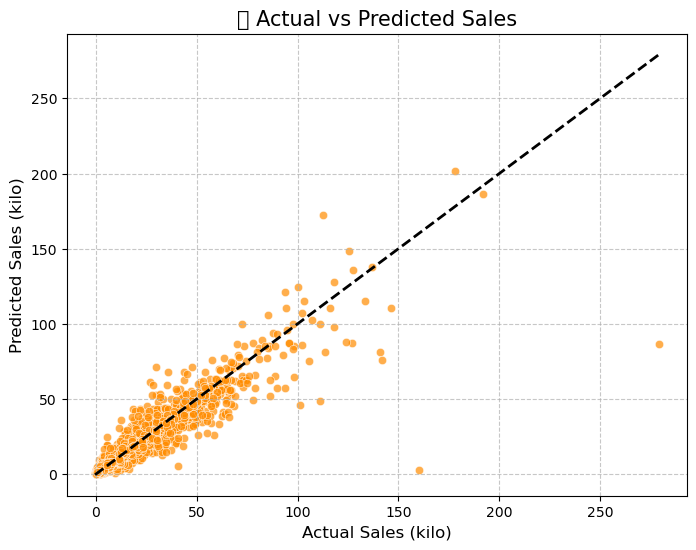

In [44]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color="darkorange", alpha=0.7)

# Add a diagonal line (ideal predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2)

plt.title("🎯 Actual vs Predicted Sales", fontsize=15)
plt.xlabel("Actual Sales (kilo)", fontsize=12)
plt.ylabel("Predicted Sales (kilo)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


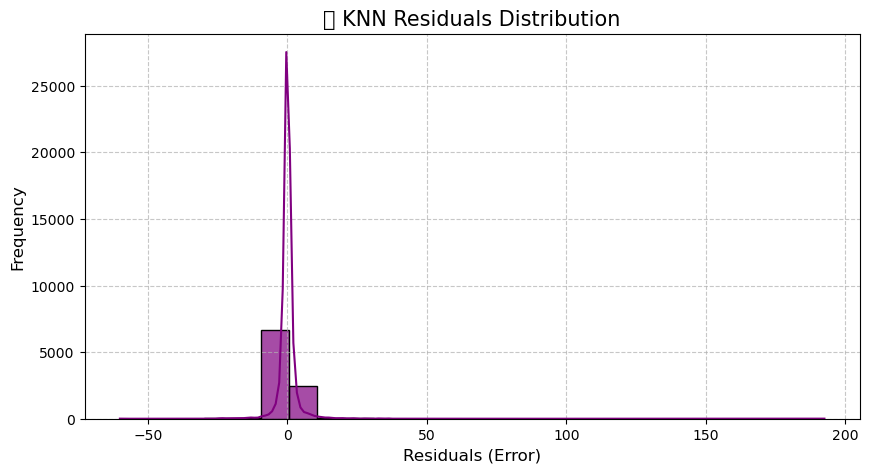

In [45]:
residuals = y_test - y_pred  # Compute residuals

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=25, color="purple", alpha=0.7)

plt.title("📊 KNN Residuals Distribution", fontsize=15)
plt.xlabel("Residuals (Error)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


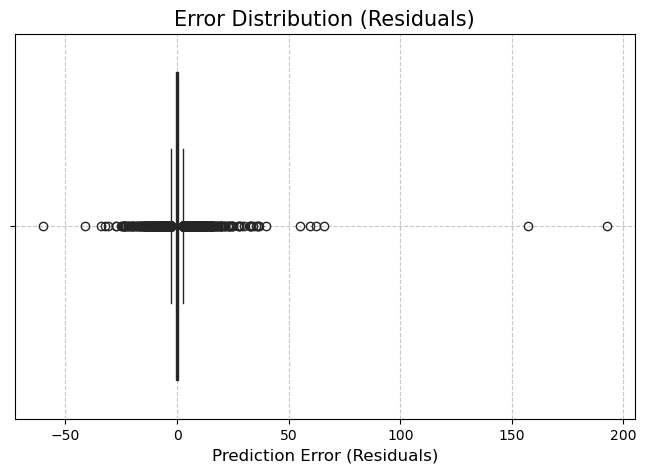

In [46]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=residuals, color="green")

plt.title("Error Distribution (Residuals)", fontsize=15)
plt.xlabel("Prediction Error (Residuals)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


### 6. Deployment
The model was tested using a real-life scenario with specific inputs like date, pricing, transaction count, and loss rate, and it predicted sales of 5.46 kg. This example highlights how the model can help in planning inventory by adjusting parameters to explore different pricing or seasonal situations. By testing various scenarios, businesses can find the best balance between revenue and waste reduction. The model’s predictions closely matched actual sales, proving it can deliver useful, practical forecasts.



### Conclusion
In conclusion we can say  that using a K-Nearest Neighbors (KNN) model can accurately predict fresh produce sales, with results good enough to guide inventory planning and reduce waste. Sales are influenced by multiple factors like price, timing, and product type, with some items showing strong price sensitivity and varying spoilage rates. These insights can help businesses make smarter decisions in stock management, pricing, and supplier negotiations. To improve the model further, more data (like weather or holidays), advanced algorithms, and real-time updates could be added. Overall, adopting data-driven strategies and investing in the right technology can enhance efficiency, reduce waste, and boost profits in the fresh produce retail space.